#### Importing Packages

In [3]:
import numpy as np
import pandas as pd
import optuna

from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

from preprocessing.ImputeMean import ImputeMean
from preprocessing.TrainTestSplit import TrainTestSplit
from preprocessing.ZeroSales import ZeroSales
from preprocessing.DataAggregator import DataAggregator
from preprocessing.FeatureEngineering import Lag, Log

from model.Train import SRX, RFR
from model.Optimize import SarimaxHyperopt

# Read data
calendar_df = pd.read_csv('E:/Documents/TanXor/Dataset/calendar.csv')
sales_df = pd.read_csv('E:/Documents/TanXor/Dataset/sales_train_validation.csv')

#### Data Transformation

In [4]:
# Initializing Parameters
date = calendar_df['date'].iloc[:1913]
col1 = 'store_id'
col2 = 'dept_id'
data = sales_df

aggreg = DataAggregator(data, col1, col2, date)

# Takes col1 and col2 and aggregates them into a new column
# Then drops col1 and col2
# Then groups by the new column
sales = aggreg.aggregate()

# Transforms the data into a time series
sales = aggreg.transform()

# Returns a dataframe with the number of zero sales for each store and department
zero_neg = ZeroSales(sales).zero_sales()

# Replace zero sales with the mean of sales of that respective store and department
ImputeMean(sales, 0).imputer()

# Splits the data into train and test sets
train_data, test_data = TrainTestSplit(sales, 0.2).data_split()

# Sets the frequency of the data to daily
train_data.index.freq = test_data.index.freq = 'd'

### Feature Engineering

In [ ]:
# Creates a new Dataframe with the following columns:
# 1. Date, 2. Actual, 3. Lagged
seasonal_lag = Lag(train_data).lag_transform(7, train_data.columns[2])

# Creates a new Dataframe with the following columns:
# 1. Date, 2. Actual, 3. LogTransformed
# train_data = Log(train_data).log_transform(train_data.columns[0])

In [ ]:
# Adds a column to the dataframe that is the difference between the actual and lagged data
seasonal_lag['diff'] = seasonal_lag[seasonal_lag.columns[0]] - seasonal_lag[seasonal_lag.columns[1]].dropna()

seasonal_lag = seasonal_lag.dropna()

### Stationarity Test

In [ ]:
# Augmented Dickey-Fuller Test (Stationarity Test)
def adfuller_test(data):
    result=adfuller(data)
    return result[1] # Return p-value

In [ ]:
# Testing for stationarity
print(adfuller_test(train_data[train_data.columns[2]]))

In [ ]:
# Testing the stationarity after differencing
print(adfuller_test(seasonal_lag[seasonal_lag.columns[-1]]))

In [ ]:
# Testing for stationarity on all columns
for i in train_data.columns[:70]:
    if (adfuller_test(train_data[i]) <= 0.05):
        print(i, "Pass")
    else:
        print(i, "Fail")

## Model Training

### SARIMAX

In [ ]:
# Set model Parameters
params = {
    'p': 1, 'd': 1, 'q': 4,
    'P': 2, 'D': 1, 'Q': 3, 's': 7
}

col = test_data.columns[0]

In [ ]:
# Initialize the model with the training data
model = SRX(train_data[col])

# Train the model on the given parameters
model.train(params)

In [ ]:
# Predict the values using the model
test_data['forecast']=model.predict(test_data[col])

# Evaluate the model on the above predictions
print(model.evaluate())

# Plot the forecast against the actuals
test_data[[col, 'forecast']].plot()

### Random Forest Regressor

In [5]:
rfr_params = {
    'n_estimators': 100,
    'max_depth': 25,
    'max_features':'log2',
    'min_samples_leaf': 10,
    'min_samples_split': 12,
    'bootstrap': False,
}

col = test_data.columns[0]

In [14]:
model = RFR(train_data[[col]])

model.data_preprocess(7)

model.train_test_split(0.2)

model.fit(rfr_params)

rfr_mape = model.evaluate()

print(f'MAPE: {rfr_mape:.2f}%')

In [8]:
rfr_data = sales[[sales.columns[0]]]

for i in range(1, 8):
    rfr_data = Lag(rfr_data).lag_transform(i, sales.columns[0])

rfr_data = rfr_data.dropna()

In [9]:
x = np.array(rfr_data.iloc[:,1]).reshape(-1,1)
for i in range(2, 8):
    xi = (np.array(rfr_data.iloc[:,i])).reshape(-1,1)
    x = np.concatenate((x, xi), axis=1)

y = np.array(rfr_data.iloc[:,0])

X_train,X_test,y_train,y_test = x[:-133],x[-133:],y[:-133],y[-133:]

In [10]:
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)
     
model.fit(X_train,y_train)

RandomForestRegressor(max_features=3, random_state=1)

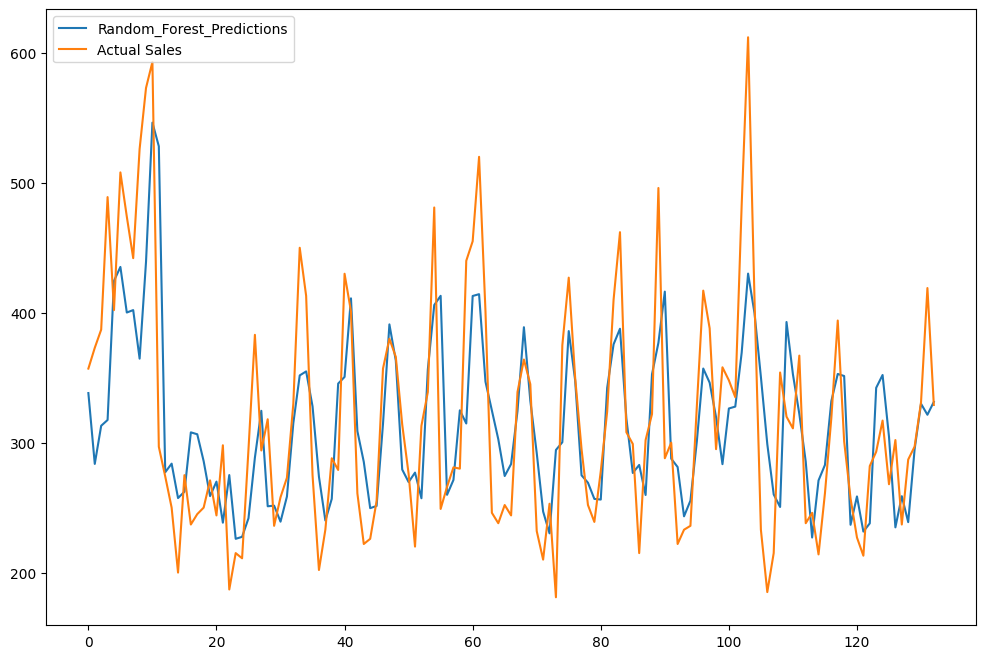

In [11]:
pred = model.predict(X_test)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [12]:
rfc_mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
print(f'MAPE: {rfc_mape:.2f}%')

MAPE: 15.88%


# Tuning

### SARIMAX_HYPEROPT

In [ ]:
# Initalize the model with the test and train data:
hp_model = SarimaxHyperopt(train_data[train_data.columns[0]], test_data[test_data.columns[0]])

# Tune the hyperparameters:
hp_model.hyperparameter_tune(num_evals=3)

# Fit the model with the best hyperparameters:
hp_model.fit()

# Predict on the test data:
pred = hp_model.predict()

# Evaluate the model using MAPE:
hp_model.evaluate(pred)

In [ ]:
# Returns the best parameters for the model
order, seasonal_order = hp_model.best_params()
print('Best parameters for the model: order={}, seasonal_order={}'.format(order, seasonal_order))

### Random Forest Regressor Optuna

In [ ]:
model = RFR(train_data[[col]])

model.data_preprocess(7)

model.train_test_split(0.2)

model.hyperparameter_tuning()

model.fit()

rfr_mape = model.evaluate()

print(f'MAPE: {rfr_mape:.2f}%')

In [ ]:
model.mape

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 50)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, bootstrap=bootstrap,
                               min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    output = reg.fit(X_train, y_train)
    predictions = output.predict(X_test)
    
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    return mape

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

In [ ]:
trial = study.best_trial
rfr_best = trial.params
print('MAPE: {}'.format(trial.value))

In [ ]:
mod = RandomForestRegressor(n_estimators=rfr_best['n_estimators'],
                            max_features=rfr_best['max_features'],
                            max_depth=rfr_best['max_depth'],
                            min_samples_leaf=rfr_best['min_samples_leaf'],
                            min_samples_split=rfr_best['min_samples_split'],
                            bootstrap=rfr_best['bootstrap'],)

X_train,X_test,y_train,y_test=x[:-113],x[-113:],y[:-113],y[-113:]
     
mod.fit(X_train,y_train)

pred = mod.predict(X_test)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

In [ ]:
mod_mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
print(f'MAPE: {mod_mape:.2f}%')

### Hyperparamter Tuning

In [ ]:
### Custom Hyperparameter Tuning ###
'''
import itertools

### Define Parameter Ranges to Test ###

# Note: higher numbers will result in code taking much longer to run
# Here we have it set to test p,d,q each = 0, 1 & 2

# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p = range(1, 6)
q = range(0, 6)
d = range(1, 2)
P = range(0, 4)
Q = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data
# You'll want to change this according to your time series' frequency
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(P, d, Q))]

### Run Grid Search ###

# Note: this code will take a while to run

# Define function
def sarimax_gridsearch(ts, pdq, pdqs, freq='D'):
    
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False, 
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=1000)
                predictions = output.predict(start=1800,end=1913,dynamic=True)

                test_data = ts.iloc[1800:1913]
                mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

                ans.append([comb, combs, output.bic, mape])
                print('SARIMAX {} x {}12 : MAPE Calculated ={}'.format(comb, combs, mape))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'mape'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['mape'],ascending=True)
    
    return ans_df
    

    ### Apply function to your time series data ###
#Remember to change frequency to match your time series data
best_params = sarimax_gridsearch(df_1['Sales'], pdq, pdqs, freq='D')
best_params.head(20)
'''

In [ ]:
### Optuna Hyperparameter Optimization ###
'''
def objective(trial):
    p = trial.suggest_int('p', 0, 6)
    # d = trial.suggest_int('d', 1, 3)
    q = trial.suggest_int('q', 0, 6)
    P = trial.suggest_int('P', 0, 6)
    Q = trial.suggest_int('Q', 0, 6)
    # m = trial.suggest_int('m', 3, 8)
    srx = sm.tsa.statespace.SARIMAX(df_1['Sales'], 
                                    order=(p,1,q), 
                                    seasonal_order=(P,1,Q,7), 
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False,
                                    freq='D')
    
    output = srx.fit(maxiter=1000)
    predictions = output.predict(start=1800,end=1913,dynamic=True)

    test_data = df_1['Sales'].iloc[1800:1913]
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
'''